# 16CygA

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
scripts_path = "../../../scripts" #os.path.join(repo_root, 'scripts')
sys.path.append(scripts_path)

import prior_funcs, utils
from pitchfuncs_ultra_pca_v2 import emulator
from pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface



import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

## Import pitchfork

In [3]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork_path = "../../../pitchfork/"

pitchfork = emulator(pitchfork_name, file_path=pitchfork_path)


with open(pitchfork_path+ pitchfork_name+'.pkl', 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

In [6]:
#parameters for star, [value,unc], NaN for not found/published
#1 : Davies, G.R, 2015
#2 : Metcalfe, T, 2012
#3 : Ramirez, Melendez, Asplund, 2009
#4 : Lund, M., 2017

star_name = '16CygA'
star_KIC = '12069424'

star_dict={}

star_dict['initial_mass']=[1.11, 0.02] #2
star_dict['initial_Zinit']= [0.024, 0.002] #2
star_dict['initial_Yinit']= [0.25, 0.01] #2
star_dict['initial_MLT']= [2.00, 0.08] #2
star_dict['star_age']=[6.8, 0.4] #2

star_dict['calc_effective_T']=[5825, 50]  #3
star_dict['radius']=[1.243, 0.008] #2
star_dict['luminosity']=[1.56, 0.05] #2
star_dict['star_feh']=[0.096, 0.026] #3


############# Freqs from table
freqs = ascii.read("../../table6.dat", readme = "../../ReadMe") 

freqs = freqs[freqs['KIC']==star_KIC]
freqs = freqs[freqs['l']==0]

i=0
for n in freqs['n']:
    freq_list = [freqs['Freq'][i], freqs['e_Freq'][i]]
    star_dict[f'nu_0_{n}'] = freq_list
    i+=1

##############

params = ascii.read(f"../../table1.dat", readme = f"../../ReadMe") 
params = params[params['KIC']==star_KIC]

star_dict['dnu'] = [params['Dnu'].value[0],0]
star_dict['nu_max'] = [float(params['numax'].value[0]),0]

with open(f'{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [1.11, 0.02],
 'initial_Zinit': [0.024, 0.002],
 'initial_Yinit': [0.25, 0.01],
 'initial_MLT': [2.0, 0.08],
 'star_age': [6.8, 0.4],
 'calc_effective_T': [5825, 50],
 'radius': [1.243, 0.008],
 'luminosity': [1.56, 0.05],
 'star_feh': [0.096, 0.026],
 'nu_0_12': [1390.80819, 0.75733],
 'nu_0_13': [1495.05303, 0.24309],
 'nu_0_14': [1598.68962, 0.07498],
 'nu_0_15': [1700.95243, 0.10148],
 'nu_0_16': [1802.35128, 0.08378],
 'nu_0_17': [1904.52077, 0.05845],
 'nu_0_18': [2007.53798, 0.04187],
 'nu_0_19': [2110.94955, 0.03737],
 'nu_0_20': [2214.22506, 0.05468],
 'nu_0_21': [2317.28211, 0.05534],
 'nu_0_22': [2420.9372, 0.08204],
 'nu_0_23': [2524.94962, 0.14781],
 'nu_0_24': [2628.92966, 0.25724],
 'nu_0_25': [2733.57075, 0.44461],
 'nu_0_26': [2840.1478, 1.05838],
 'nu_0_27': [2944.93722, 0.89642],
 'dnu': [103.3, 0],
 'nu_max': [2188.0, 0]}

## define priors

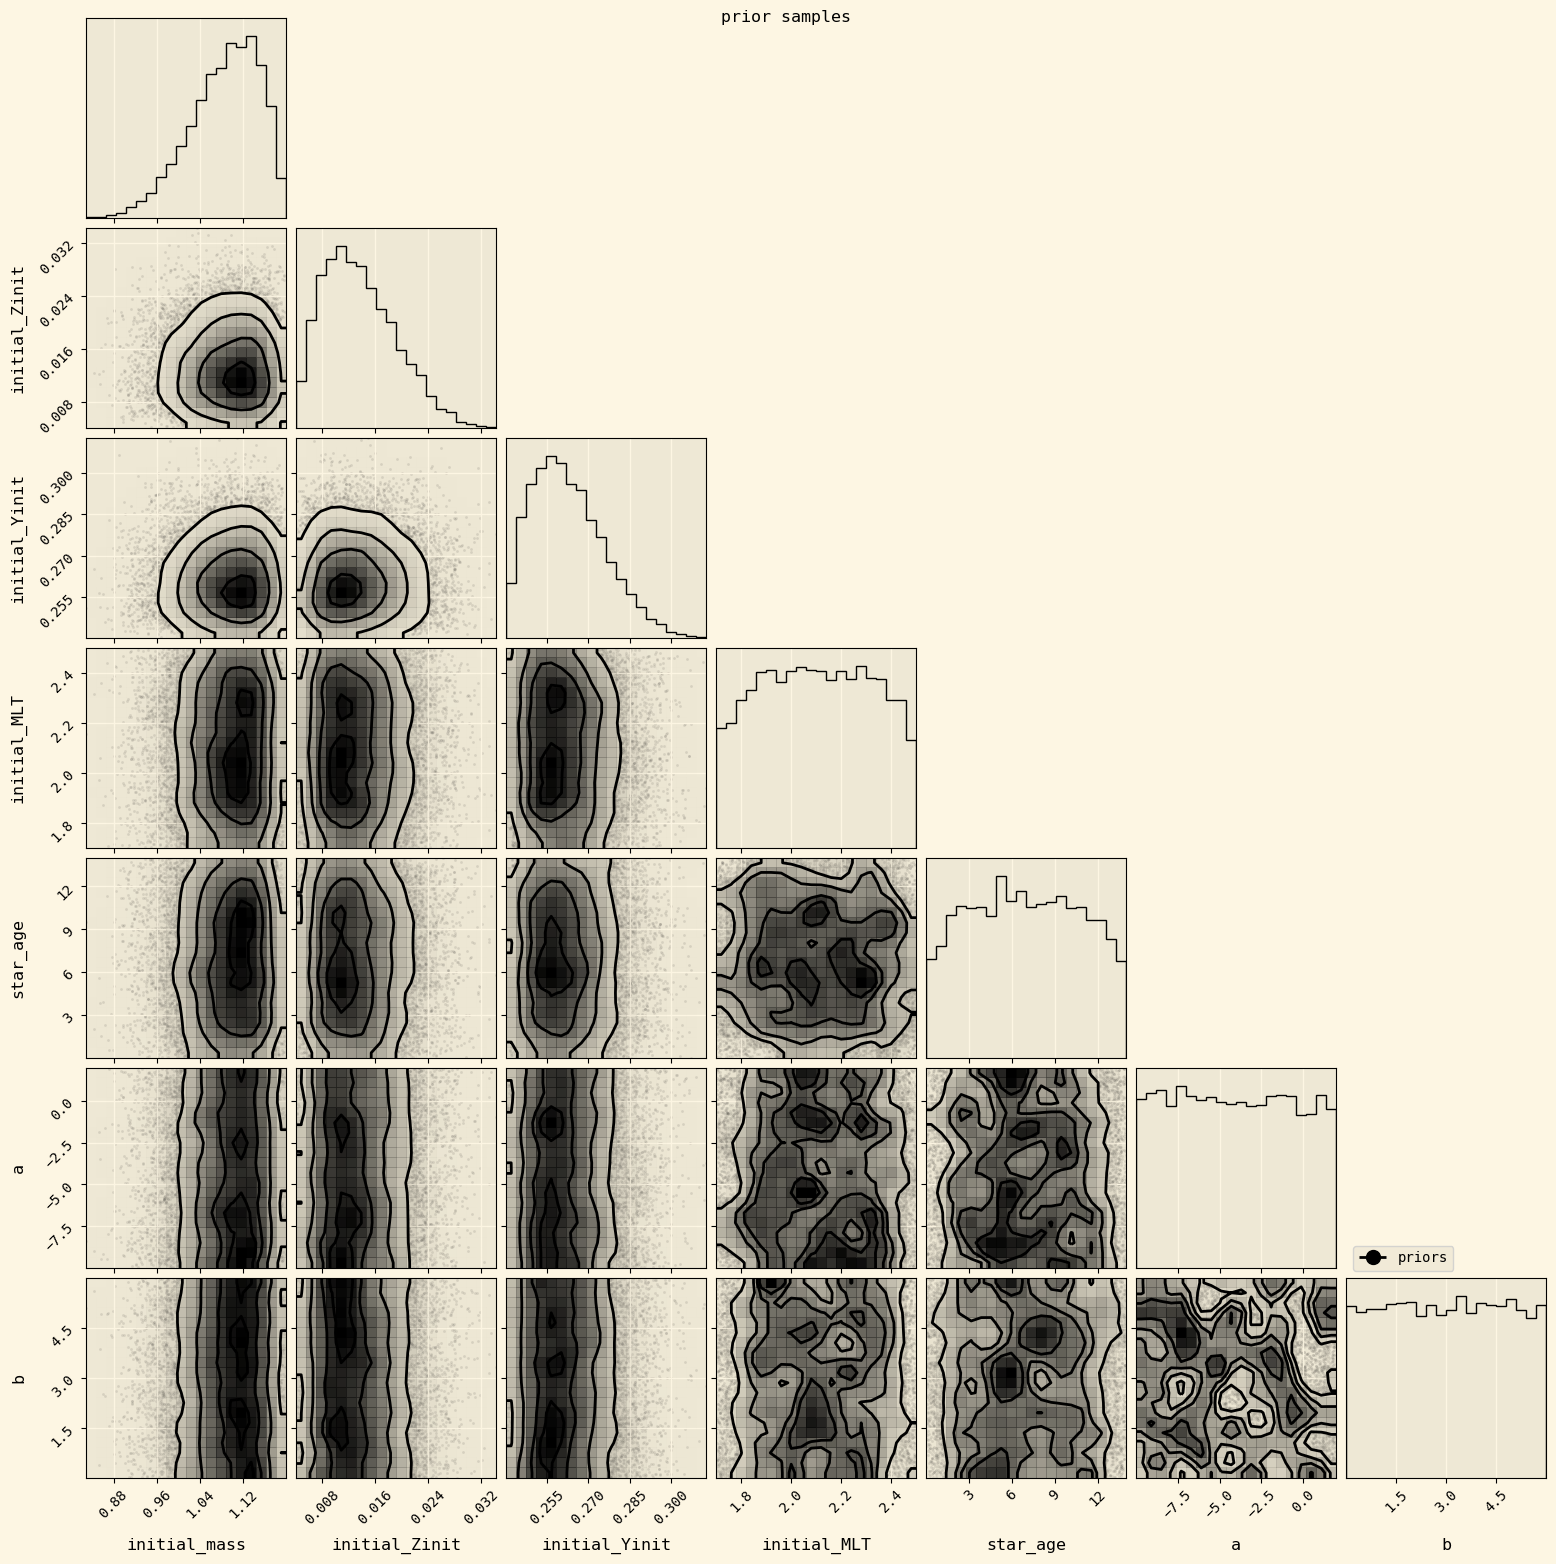

In [7]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(0, 6)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [8]:
star_json = f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
with open(pitchfork_path+ "/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 7*kernels.ExpSquared(scale=7*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [10]:
%%time

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

    
ndraw_min=2**16
ndraw_max=2**19
min_num_live_points = 256

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = ultra_ns_vector_surface(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.1)#, max_ncalls=5e6)

with open('samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()

del results

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|           1.11 |           0.024 |            0.25 |             2 |        6.8 |


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


CPU times: user 1min 45s, sys: 779 ms, total: 1min 46s951]*| it/evals=3528/259725 eff=1.3597% N=256 
Wall time: 1min 44s


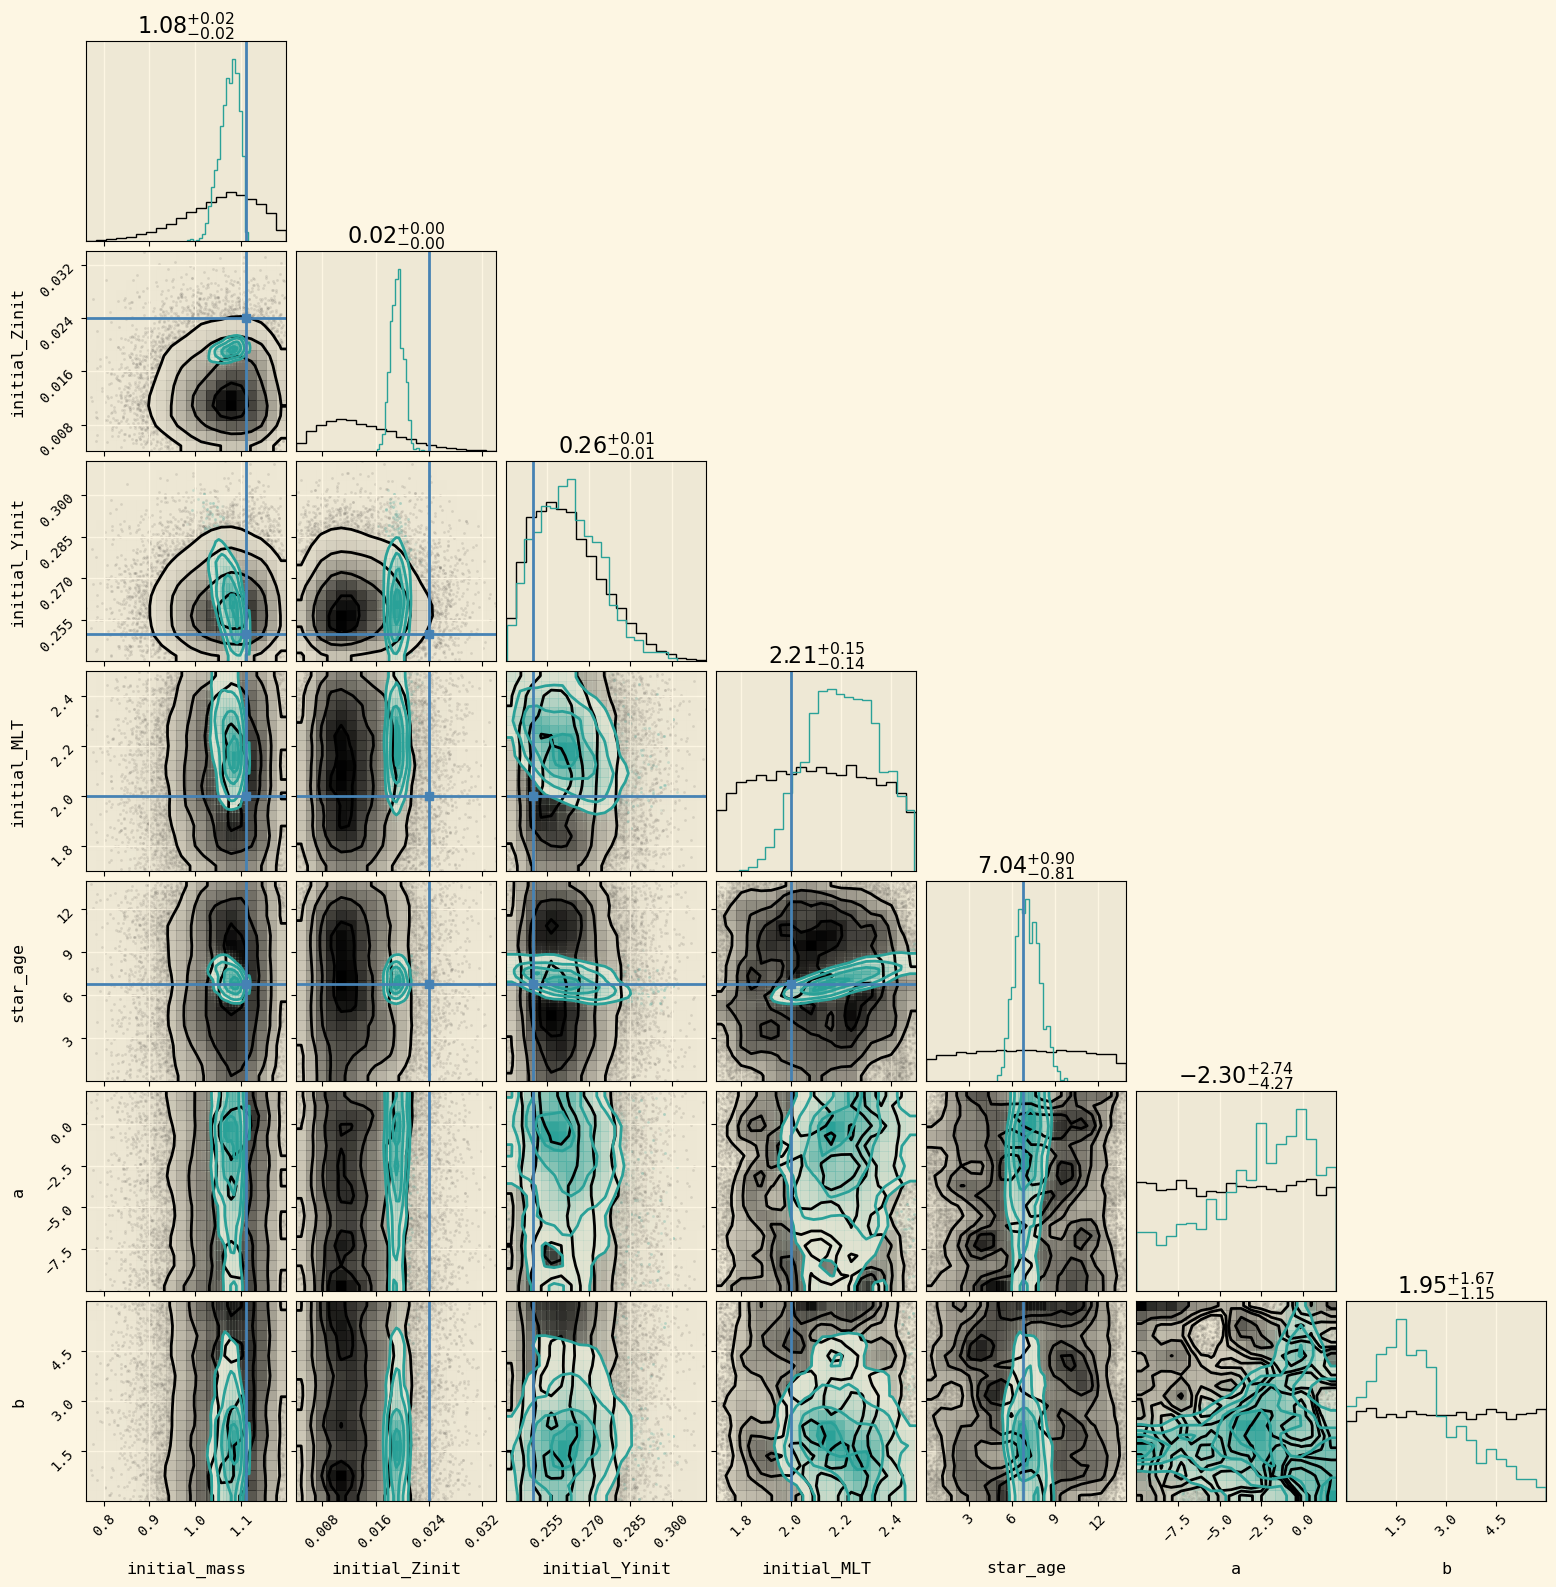

In [11]:
def inspect_star(path):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.7, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(0, 6)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    

    star_json = f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open('samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)

    
    corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);

    plt.show()

    
inspect_star(star_name)

# Posterior Predictive

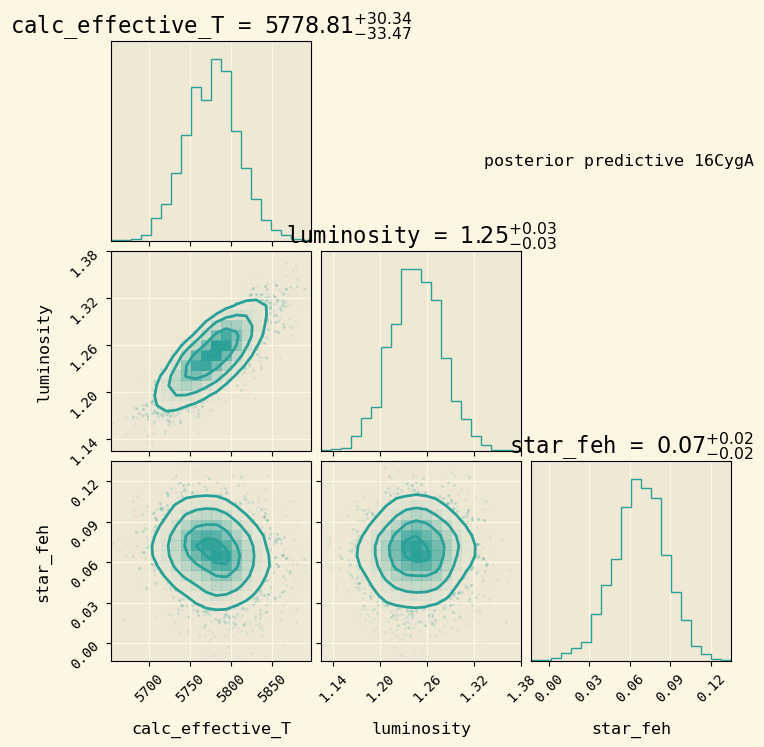

          nu_0_12      nu_0_13      nu_0_14      nu_0_15      nu_0_16  \
0     1576.125764  1693.375817  1810.503412  1926.816867  2042.453590   
1     1577.166671  1694.383513  1811.355402  1927.506820  2043.048935   
2     1576.668814  1693.783685  1810.740251  1927.002131  2042.686642   
3     1575.518126  1692.647602  1809.673439  1925.978300  2041.667089   
4     1577.977681  1695.342771  1812.541545  1928.894020  2044.569778   
...           ...          ...          ...          ...          ...   
6895  1577.643137  1694.997998  1812.269948  1928.818572  2044.728580   
6896  1575.768953  1692.938512  1809.989949  1926.265750  2041.877255   
6897  1576.652751  1693.852307  1810.918604  1927.234764  2042.927447   
6898  1576.413206  1693.562580  1810.539860  1926.763140  2042.375280   
6899  1577.205309  1694.563896  1811.881897  1928.432311  2044.290551   

          nu_0_17      nu_0_18      nu_0_19      nu_0_20      nu_0_21  \
0     2158.151876  2274.501918  2391.497908  2508.

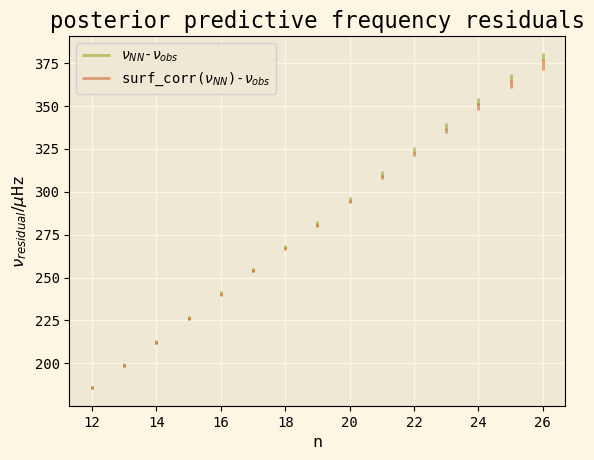

In [202]:
def posterior_pred(pitchfork, samples, star_name):

    path = f'stars/{star_name}/'

    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)
    
    star_vals_df = star_df.iloc[[0]]
    
    star_uncs_df = star_df.iloc[[1]]
    
    star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)
    
    nu_max = star_df["nu_max"].values[0]
    
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

    samples_df = pd.DataFrame(samples['samples'], columns=labels)

    preds_array = pitchfork.predict(samples_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']])
    output_labels = ["calc_effective_T", "luminosity", "star_feh"] + [
        f"nu_0_{i}" for i in range(6, 41)
    ]
    
    preds_df = pd.DataFrame(preds_array, columns=output_labels)


    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    figure = corner.corner(preds_df[["calc_effective_T", "luminosity", "star_feh"]], labels = ["calc_effective_T", "luminosity", "star_feh"], color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle(f'posterior predictive {star_name}', x=0.8, y=0.8)
    plt.show()

    ### freqs posterior preds

    n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
    n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))
    pred_freqs = preds_df[[f"nu_0_{i}" for i in range(n_min, n_max)]]
    print(pred_freqs)
    

    ## corrected freq posterior pred
    def surf_corr(freqs, nu_max, a, b):
        return freqs + a * ((freqs / nu_max) ** b)

    a_samples = samples_df['a'].values
    b_samples = samples_df['b'].values
    
    for n in range(n_min, n_max):
        n_samples = pred_freqs[f"nu_0_{n}"].values
        observed_freqs = star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1)[f"nu_0_{n}"].values
        print(observed_freqs)

        n_samples_residual = n_samples - np.full(len(n_samples),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std
        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2], label=r'$\nu_{NN}$-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[2],alpha=.5)


        
        n_samples_corr = surf_corr(n_samples, nu_max, a_samples, b_samples)
        
        n_samples_residual = n_samples_corr - np.full(len(n_samples_corr),observed_freqs)

        ### keep for lines
        n_samples_residual_mu = n_samples_residual.mean()
        n_samples_residual_std = n_samples_residual.std()

        plot_upper = n_samples_residual_mu + n_samples_residual_std
        plot_lower = n_samples_residual_mu - n_samples_residual_std

        if n == n_min:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4], label=r'surf_corr($\nu_{NN}$)-$\nu_{obs}$',alpha=.5)
        else:
            plt.plot(np.full(2, n), np.array([plot_upper, plot_lower]),c=colors[4],alpha=.5)
        ###

        ### keep for points
        #plt.scatter(np.full(len(n_samples_residual), n), n_samples_residual,c=colors[2], alpha=0.002)
    
        ###

    plt.legend()
    plt.xlabel('n')
    plt.ylabel(r'$\nu_{residual}/\mu$Hz')
    plt.title('posterior predictive frequency residuals')
    plt.show()

posterior_pred(pitchfork, samples, star_name)

In [191]:
star_obs_vals_df

,calc_effective_T,luminosity,star_feh,nu_0_12,nu_0_13,nu_0_14,nu_0_15,nu_0_16,nu_0_17,nu_0_18,nu_0_19,nu_0_20,nu_0_21,nu_0_22,nu_0_23,nu_0_24,nu_0_25,nu_0_26,nu_0_27
0,5825,1.56,0.096,1390.80819,1495.05303,1598.68962,1700.95243,1802.35128,1904.52077,2007.53798,2110.94955,2214.22506,2317.28211,2420.9372,2524.94962,2628.92966,2733.57075,2840.1478,2944.93722


In [199]:
pred_freqs

NameError: name 'pred_freqs' is not defined